In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd.profiler as profiler

def const(x):
    return 1

def linear(x):
    return x

def quad(x):
    return x ** 2

def cubic(x):
    return x ** 3

def quartic(x):
    return x ** 4

def quintic(x):
    return x ** 5

def exp(x):
    return torch.exp(x)

# Mean square error
class MSE(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        error = torch.pow(y_t - y_prime_t, 2)
        return torch.sum(error)

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = 10* (y_t - y_prime_t)
        return torch.mean(torch.log(torch.cosh(ey_t)))

        
def design_matrix(times, basis):
    mat = torch.DoubleTensor([[func(time) for func in basis] for time in times])
    return mat

def ls_fit(xdata, ydata, design_mat):
    pseudo_inv = torch.linalg.pinv(design_mat)
    return torch.sum(pseudo_inv * ydata, dim = 1)

def piecewise_fit(x, y, slice_loc, design_mat):
    calc = MSE()
    segments = slice_loc.shape[0] + 1
    samples = x.shape[0]
    fit = torch.empty_like(y)
    for i in range(segments):
        if (i == 0):
            ind = [0,int(slice_loc[0])]
        elif (i == segments - 1):
            ind = [int(slice_loc[-1]),samples]
        else:
            ind = [int(slice_loc[i-1]),int(slice_loc[i])]

        xdata = x[ind[0]:ind[1]]
        ydata = y[ind[0]:ind[1]]
        mat = design_mat[ind[0]:ind[1]]
        fit_params = ls_fit(xdata, ydata, mat)
        fit[ind[0]:ind[1]] = torch.sum(mat * fit_params, dim=1)
    loss = calc(y, fit)
    return [fit, loss]


class Slicer(nn.Module):
    def __init__(self, segments, times, basis):
        super().__init__()
        torch.autograd.set_grad_enabled(False)
        self.times = times
        self.samples = times.shape[0]
        self.segments = segments
        self.basis = basis
        self.design_mat = design_matrix(self.times, self.basis)
        self.register_parameter(name='slice_loc', param = torch.nn.Parameter(torch.sort(self.samples * torch.rand(self.segments - 1))[0]))
    def forward(self, y):
        self.slice_loc[torch.where(self.slice_loc < 0)] = 0
        self.slice_loc[torch.where(self.slice_loc >= self.samples)] = self.samples - 1
        return piecewise_fit(self.times, y, self.slice_loc, self.design_mat)

def optimize(model, optim, y, iter=100):
    grad = torch.empty_like(model.slice_loc)
    for j in range(iter):
        for i, param in enumerate(model.slice_loc):
            param += 1
            _,lossp = model(y)
            param -= 2
            _,lossn = model(y)
            param += 1
            grad[i] = (lossp-lossn) 
        model.slice_loc.grad = grad
        optim.step()
    
def random_search(model, y, samples=10000):
    best = model.slice_loc
    _,bestloss = model(y)
    for i in range(samples):
        model.slice_loc = torch.nn.Parameter(torch.sort(y.shape[0] * torch.rand_like(model.slice_loc))[0])
        if (model(y)[1] < bestloss):
            best = model.slice_loc
            _,bestloss = model(y)
    return best

tensor(66.4470)
[Parameter containing:
tensor([860.0086], requires_grad=True)]


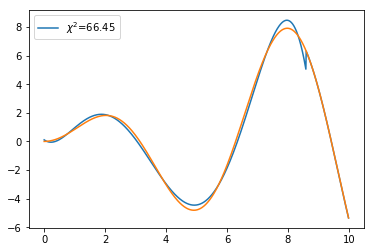

tensor(0.5537)
[Parameter containing:
tensor([418.5279], requires_grad=True)]


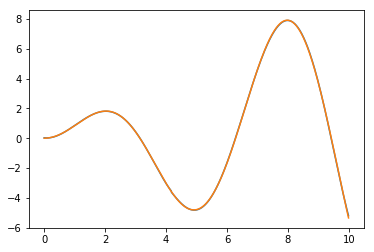

tensor(0.5537)


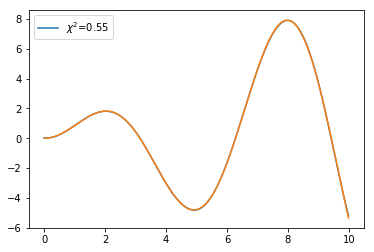

tensor(0.5537)


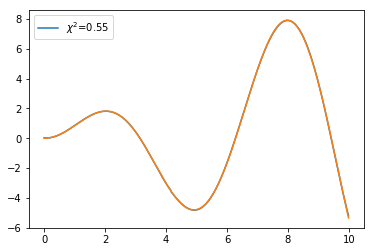

tensor(0.5539)


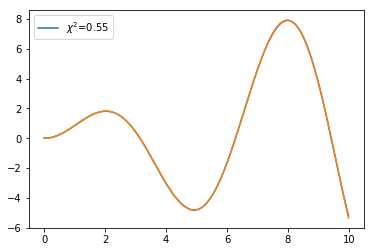

tensor(0.5537)


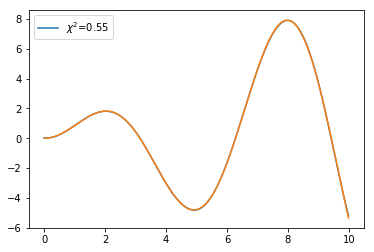

tensor(0.5537)


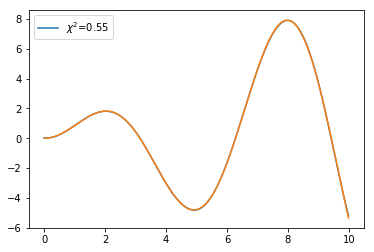

tensor(0.5537)


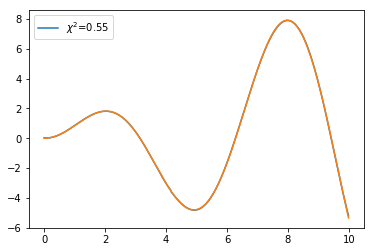

tensor(0.5539)


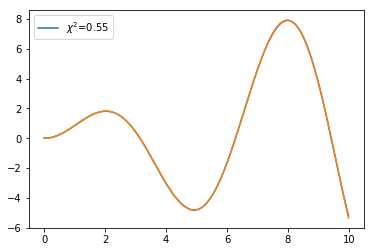

tensor(0.5537)


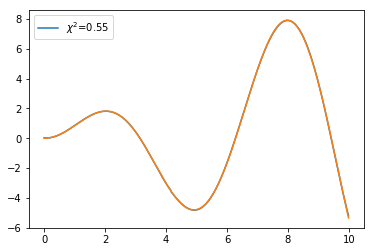

tensor(0.5539)


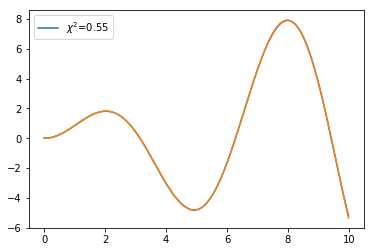

tensor(0.5537)


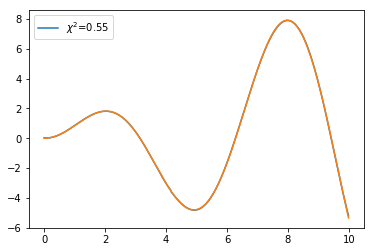

[Parameter containing:
tensor([417.2816], requires_grad=True)]


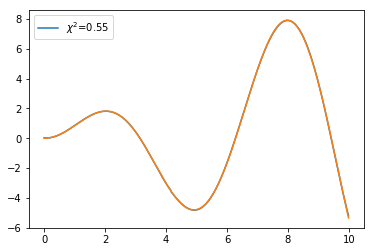

In [6]:
#torch.manual_seed(1)
t = torch.arange(0,10,0.01)
y = t * torch.sin(t)
basis = [const, linear, quad, cubic, quartic, quintic]
segments = 2
model = Slicer(segments, t, basis)
fit, loss = model(y)
print(loss)
print(list(model.parameters()))
plt.plot(t, fit, label="$\chi^2$=%.2f" % loss.item())
plt.plot(t, y)
plt.legend()
plt.show()

# "Fast" random search, no point for this without a GPU

model.slice_loc = random_search(model, y, 10000)
fit, loss = model(y)
print(loss)
print(list(model.parameters()))
plt.plot(t, fit)
plt.plot(t, y)
plt.show()


# Optimizing using ADAM

optim = torch.optim.Adam(model.parameters(), lr=5)
for i in range(10):
    optimize(model, optim, y, 100)
    fit, loss = model(y)
    print(loss)
    plt.plot(t, fit, label="$\chi^2$=%.2f" % loss.item())
    plt.plot(t, y)
    plt.legend()
    plt.show()
    

print(list(model.parameters()))
plt.plot(t, fit, label="$\chi^2$=%.2f" % loss.item())
plt.plot(t, y)
plt.legend()
plt.show()


# # Profiling
# optim = torch.optim.Adam(model.parameters(), lr=5)
# with profiler.profile(with_stack=True, profile_memory=False) as prof:
#     for i in range(1):
#         optimize(model, optim, y, 5)
#         fit, loss = model(y)
#         print(loss)
# print(prof.key_averages(group_by_stack_n=10).table(sort_by='self_cpu_time_total', row_limit=20))